### Notebook Update:
* Compare the performance of **ML using sklearn** and **DL using tensorflow**

# Table of Contents

* [Overview](#0)
* [Importing Libraries](#1)
* [Load Dataset](#2)
* [Data Visualization](#3)
* [Text Preprocessing](#4)
* [Building Model with Sklearn](#5)
* [Building Model with Tensorflow](#6)
* [Prediction](#7)

In [17]:
# nltk is one of the most useful libraries when it comes to nlp
!pip install nltk

<a id="0"></a>
# Overview

In this notebook, we are going to do semantic analysis on hotel reviews from Tripadvisor. We will 2 different approaches:
1. With machine learning models using sklearn
2. With deep neural network using tensorflow

There are also some text preprocessing before we train our model to make sure that our data is clean. At the end of this notebook, we will try to predict the sentiment of our own review

**So, let's dive into the code!**

<a id="1"></a>
# Importing Libraries

In [18]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

<a id="1"></a>
# Load Dataset

In [19]:
df = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


As you can see from above details, there is **no null values** in this dataset

<a id="3"></a>
# Data Visualization

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

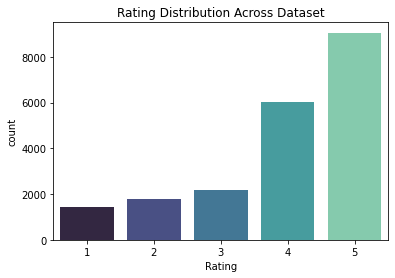

In [21]:
sns.countplot(data=df, x='Rating', palette='mako').set_title('Rating Distribution Across Dataset')

In [22]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


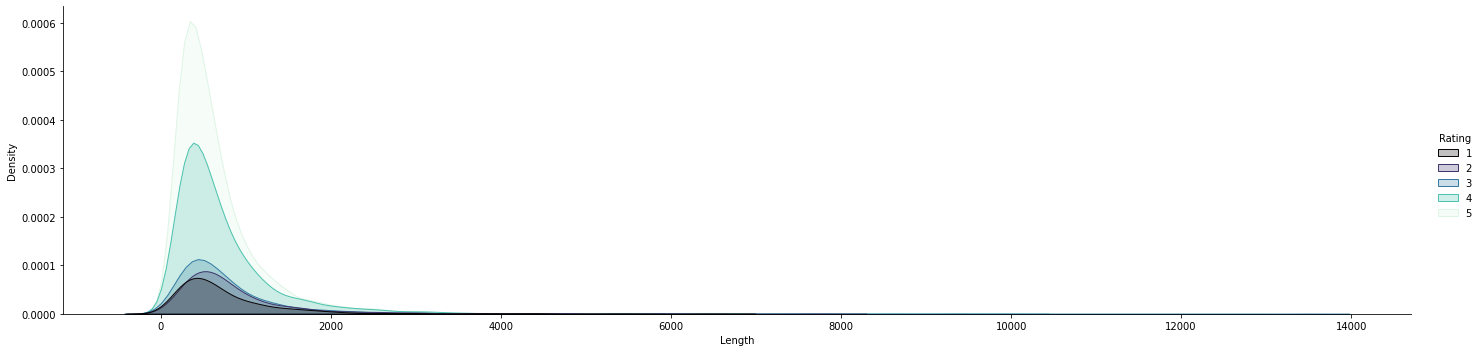

In [23]:
sns.displot(data=df, x='Length', hue='Rating', palette='mako', kind='kde', fill=True, aspect=4)

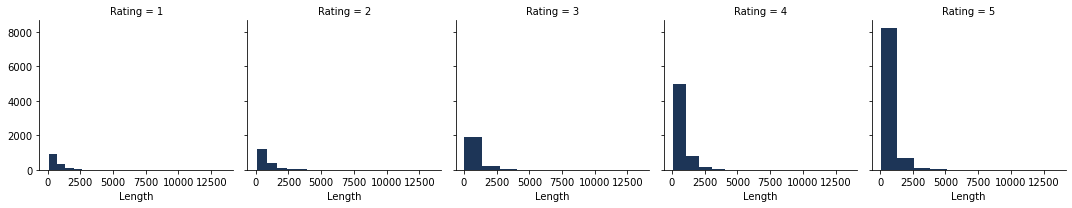

In [24]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#1D3557')

<AxesSubplot:xlabel='Rating', ylabel='Length'>

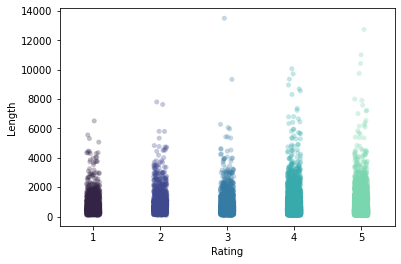

In [25]:
sns.stripplot(data=df, x='Rating', y='Length', palette='mako', alpha=0.3)

From above plot we can say that **the higher the rating of the hotel, the more likely the visitors wrote a long review**

<a id="4"></a>
# Text Preprocessing

In [26]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [27]:
df['Rating'] = df['Rating'].apply(rating)

In [28]:
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Good,593
1,ok nothing special charge diamond member hilto...,Bad,1689
2,nice rooms not 4* experience hotel monaco seat...,Netral,1427
3,"unique, great stay, wonderful time hotel monac...",Good,600
4,"great stay great stay, went seahawk game aweso...",Good,1281


In [29]:
# Total word in dataset before cleaning
length = df['Length'].sum()

### Stemming vs Lemmatization
I think this picture can give you a sense of what is the different between stemming and lemmatization

![image](https://lh3.googleusercontent.com/BP5TVAfMRDWXufbDRorQs0s84WXcrmYEuru1tLrSBOd_xTtv06f2qld5VMXIvA_Y0iqeG__w0iXsTeZj9fSpocIx7eEZSqbY_gDihdIAHwuqlPSK244_IfK9tXaow3-Y3ftpW5WxEJ_58Meukw)

In [30]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

There are some difference among those 3 sentences, for instance:
* Original -> got, arrived
* Stemming -> got, arriv
* Lemmatization -> get, arrive

This time, we will use Lemmatization in order to get the base form of the word

In [31]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [32]:
df['Review'] = df['Review'].apply(cleaning)

In [33]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

Total word before cleaning: 14853861
Total word after cleaning: 13543965


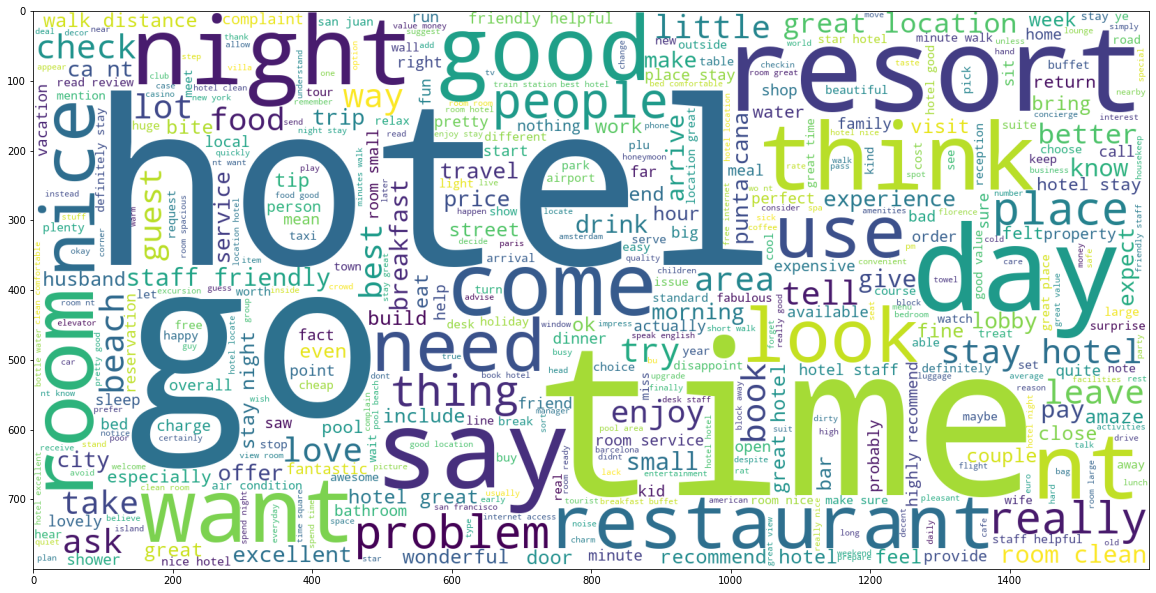

In [95]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(' '.join(df['Review']))

plt.imshow(wc)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

<a id="5"></a>
# Building Model with Sklearn

In [53]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [54]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [55]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

In [56]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.738776
1,RandomForestClassifier,0.780564
2,SVC,0.852489
3,LogisticRegression,0.856821
4,KNeighborsClassifier,0.784225
5,BernoulliNB,0.754209


Since Logistic Regression performs better than other models in this case, we will use it to train our model

In [57]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [58]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 463  120   38]
 [  32 2973   31]
 [  81  275   86]]
              precision    recall  f1-score   support

         Bad       0.80      0.75      0.77       621
        Good       0.88      0.98      0.93      3036
      Netral       0.55      0.19      0.29       442

    accuracy                           0.86      4099
   macro avg       0.75      0.64      0.66      4099
weighted avg       0.84      0.86      0.84      4099



<a id="6"></a>
# Building Model with Tensorflow

In [79]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 64776


In [80]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                                                          bias_regularizer=l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 8)           518208    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 32)                3200      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 27        
Total params: 521,699
Trainable params: 521,699
Non-trainable params: 0
________________________________________________

In [81]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
513/513 [==============================] - 56s 104ms/step - loss: 0.9677 - accuracy: 0.6615 - val_loss: 0.7780 - val_accuracy: 0.7407
Epoch 2/25
513/513 [==============================] - 53s 104ms/step - loss: 0.8375 - accuracy: 0.7086 - val_loss: 0.6744 - val_accuracy: 0.7407
Epoch 3/25
513/513 [==============================] - 53s 103ms/step - loss: 0.7250 - accuracy: 0.7297 - val_loss: 0.6098 - val_accuracy: 0.7407
Epoch 4/25
513/513 [==============================] - 52s 102ms/step - loss: 0.6428 - accuracy: 0.7331 - val_loss: 0.5320 - val_accuracy: 0.7407
Epoch 5/25
513/513 [==============================] - 53s 102ms/step - loss: 0.5768 - accuracy: 0.7340 - val_loss: 0.5077 - val_accuracy: 0.7407
Epoch 6/25
513/513 [==============================] - 52s 102ms/step - loss: 0.5503 - accuracy: 0.7454 - val_loss: 0.4974 - val_accuracy: 0.7455
Epoch 7/25
513/513 [==============================] - 52s 102ms/step - loss: 0.5175 - accuracy: 0.7873 - val_loss: 0.4993 - val_ac

<AxesSubplot:>

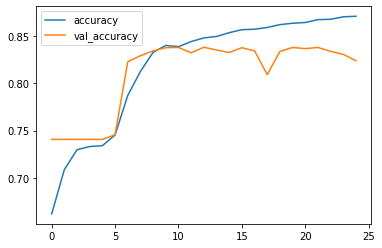

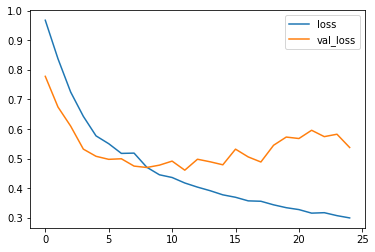

In [82]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [83]:
pred2 = model.predict(test_padded)

In [84]:
true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred2, axis=-1)

In [85]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[ 522   77   22]
 [ 163 2821   52]
 [ 212  195   35]]
              precision    recall  f1-score   support

           0       0.58      0.84      0.69       621
           1       0.91      0.93      0.92      3036
           2       0.32      0.08      0.13       442

    accuracy                           0.82      4099
   macro avg       0.61      0.62      0.58      4099
weighted avg       0.80      0.82      0.80      4099



<a id="7"></a>
# Prediction

Let's make some prediction using the model we have trained. You can create your own reviews and let the model predict the sentiment in your text

In [86]:
# Logistic Regression
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred = log.predict(tfid_matrix)[0]
    
    return pred

# Deep Neural Network
def dl_predict(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [87]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))
print('Prediction using DNN: {}'.format(dl_predict(text)))

Prediction using Logistic Regression: Good
Prediction using DNN: Good


In [88]:
text2 = 'Awful room services and slow wifi connection'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text2)))
print('Prediction using DNN: {}'.format(dl_predict(text2)))

Prediction using Logistic Regression: Bad
Prediction using DNN: Bad


In [74]:
text3 = 'Hard to get here but the scenery is wonderful'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text3)))
print('Prediction using DNN: {}'.format(dl_predict(text3)))

Prediction using Logistic Regression: Good
Prediction using DNN: Netral


#### If you find this notebook useful, please upvote👍
#### Thanks